# Make Pyramid
Implement [ndpyramid](https://github.com/carbonplan/ndpyramid/tree/main) (Credit: Carbonplan) to create a pyramid datatree.datatree 'pyramid' in which each level has a higher resolution. Such pyramids are compatible with several Carbonplan webviewer and can be tested in [ncview](https://ncview-js.staging.carbonplan.org/)
## Install Resampling

In [1]:
!pip install -q "git+https://github.com/willem0boone/Edito_resampling_datasets#egg=resampling[git_deps]"

DEPRECATION: git+https://github.com/willem0boone/Edito_resampling_datasets#egg=resampling[git_deps] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617


## Imports 

In [2]:
import sys
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import sys
print(sys.executable)

/opt/conda/bin/python


#### Import Resampling modules

In [6]:
from resampling.my_store import get_my_store
from resampling.transform import make_pyramid
from resampling.transform import expand_to_global_coverage

/opt/conda/lib/python3.12/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.blob.core.windows.net/carbonplan-data'].
  warnings.warn(msg)


## Load datasets
This function loads the datasets into one singe xarray.Dataset. 

In [4]:
def extract_all_ds():

    my_dataset = xr.Dataset()
    
    bathy = "https://minio.lab.dive.edito.eu/oidc-willemboone/EDITO_DUC/EDITO_DUC_bathymetry.zarr"
    saly = "https://minio.lab.dive.edito.eu/oidc-willemboone/EDITO_DUC/EDITO_DUC_SALINITY_baseline.zarr"
    temp = "https://minio.lab.dive.edito.eu/oidc-willemboone/EDITO_DUC/EDITO_DUC_SST_baseline.zarr"

    ds_bathy = xr.open_zarr(bathy)   
    ds_saly = xr.open_zarr(saly).sel(time="2010-01-01")
    ds_temp = xr.open_zarr(temp).sel(time="2010-01-01")

    
    my_dataset["saly"] = xr.DataArray(ds_saly["average_sea_water_practical_salinity_biooracle_baseline"].values,
                                 dims=("latitude", "longitude"),
                                 coords={"latitude": ds_saly.latitude.values,
                                         "longitude": ds_saly.longitude.values}
                                )
    
    my_dataset["SST"] = xr.DataArray(ds_temp["average_sea_water_temperature_biooracle_baseline"].values,
                                     dims=("latitude", "longitude"),
                                     coords={"latitude": ds_temp.latitude.values,
                                             "longitude": ds_temp.longitude.values}
                                    )
    my_dataset["elevation"] = xr.DataArray(ds_bathy["elevation"].values,
                                           dims=("latitude", "longitude"),
                                          )
    return my_dataset

In [5]:
ds = extract_all_ds()
print(ds)

<xarray.Dataset> Size: 5MB
Dimensions:    (latitude: 400, longitude: 500)
Coordinates:
  * latitude   (latitude) float64 3kB 69.95 69.85 69.75 ... 30.25 30.15 30.05
  * longitude  (longitude) float64 4kB -9.95 -9.85 -9.75 ... 39.75 39.85 39.95
Data variables:
    saly       (latitude, longitude) float64 2MB 34.84 34.84 34.84 ... nan nan
    SST        (latitude, longitude) float64 2MB 3.64 3.665 3.681 ... nan nan
    elevation  (latitude, longitude) float64 2MB -2.067e+03 -1.944e+03 ... nan


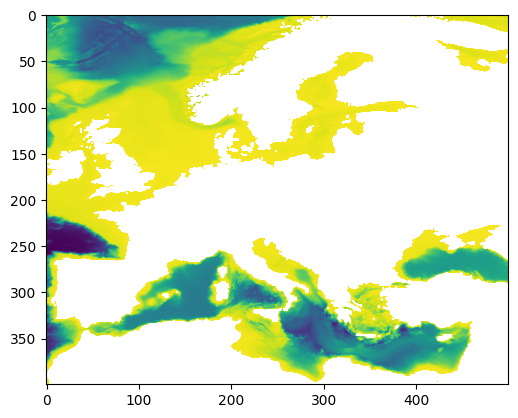

In [6]:
plt.imshow(ds["elevation"])

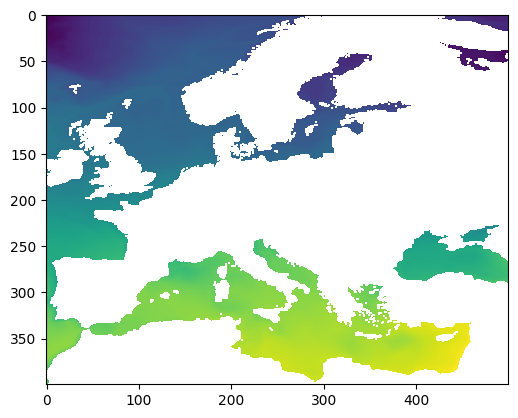

In [7]:
plt.imshow(ds["SST"])

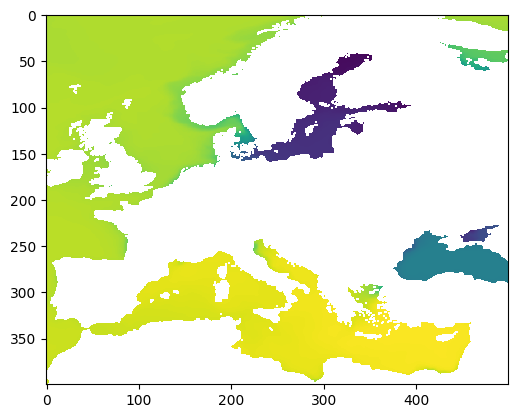

In [8]:
plt.imshow(ds["saly"])

#### Expand to global coverage, make sure the lat & lon step are conform the lat/lon resolution of the dataset
Carbonplan maps requires the datasets to have a global extend. Therefore the function *expand_to_global_coverage* can be used.

In [9]:
global_ds = expand_to_global_coverage(ds, step_lon=0.1, step_lat=0.1)
print(global_ds)

<xarray.Dataset> Size: 156MB
Dimensions:    (latitude: 1801, longitude: 3601)
Coordinates:
  * latitude   (latitude) float64 14kB -90.0 -89.9 -89.8 ... 89.8 89.9 90.0
  * longitude  (longitude) float64 29kB -180.0 -179.9 -179.8 ... 179.9 180.0
Data variables:
    saly       (latitude, longitude) float64 52MB nan nan nan ... nan nan nan
    SST        (latitude, longitude) float64 52MB nan nan nan ... nan nan nan
    elevation  (latitude, longitude) float64 52MB nan nan nan ... nan nan nan


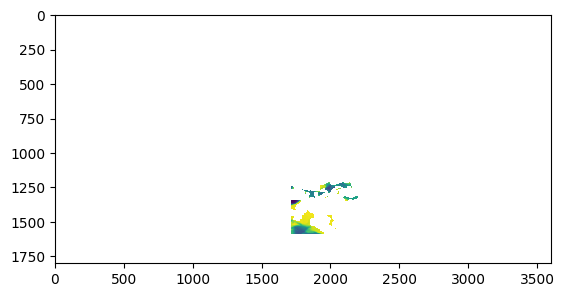

In [10]:
plt.imshow(global_ds["elevation"])

Notice that matplotlib & xarray don't always understands the meaning of latitude/longitude as geographical coordinates. On the y axis, coordinates go from 1800 (north pole) to 900 (equator) to 0 (south pole). Notice that this is high to low while the plot uses low to high. so the plotting of the map is mirrored but it doesn't affect the dataset and pyramid building.

#### Create the pyramid

In [11]:
merged_pyramid = make_pyramid(
    ds=ds,
    pixels_per_tile=128,
    version=0.17,
    levels=6,
)
print(merged_pyramid)

start reproject
DataTree('root')
├── DataTree('0')
│   Dimensions:        (x: 128, y: 128, variable: 4)
│   Coordinates:
│     * x              (x) float32 512B -1.987e+07 -1.956e+07 ... 1.987e+07
│     * y              (y) float32 512B 1.989e+07 1.958e+07 ... -1.989e+07
│       spatial_ref    int32 4B 0
│     * variable       (variable) <U50 800B 'saly' 'SST' 'elevation' 'area'
│   Data variables:
│       all_variables  (variable, y, x) float32 262kB dask.array<chunksize=(4, 128, 128), meta=np.ndarray>
├── DataTree('1')
│   Dimensions:        (x: 256, y: 256, variable: 4)
│   Coordinates:
│     * x              (x) float32 1kB -1.995e+07 -1.979e+07 ... 1.979e+07 1.995e+07
│     * y              (y) float32 1kB 1.997e+07 1.981e+07 ... -1.981e+07 -1.997e+07
│       spatial_ref    int32 4B 0
│     * variable       (variable) <U50 800B 'saly' 'SST' 'elevation' 'area'
│   Data variables:
│       all_variables  (variable, y, x) float32 1MB dask.array<chunksize=(4, 128, 128), meta=np.ndarray

### Save to S3 store

In [12]:
my_store = get_my_store()

In [13]:
my_store.write_zarr(merged_pyramid, name="tutorial_pyramid.zarr")

### Make public accessible
Run this command in a terminal in the datalab to make your dataset public available: <br>
*mc anonymous set public "s3/oidc-willemboone/tutorial_pyramid.zarr"*
<br><br>
Copy the link of your dataset: <br>
    *https://minio.lab.dive.edito.eu/oidc-willemboone/EDITO_DUC/tutorial_pyramid.zarr*
<br><br>
And visualise is in this webviewer: https://ncview-js.staging.carbonplan.org/